<a href="https://colab.research.google.com/github/predicthq/phq-data-science-docs/blob/master/academic-events/part_3_feature_engineering.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Academic Events Data Science Guides

# Part 3: Feature Engineering

<b>A How To Guide to aggregating data and creating features for forecasting from PredictHQ's Academic Events.</b>

Designing features for forecasting will be affected by what you are forecasting and what you are trying to optimize.

The findings of Part 2 can be used to influence decisions dependant on your business domain. 

This notebook proposes three business-agnostic case studies. These case studies provide examples of how you might aggregate academic event data. Each case study is connected to a example but might be equally suitable to another business vertical. These are by no means exhaustive but, might provide inspiration for where to start based on your own use case. 

### [Case 1](#case_1)
- Daily forecasting
- Features for each sub category
- Radius 10 miles around latitude and longitude

Example: Fast Food Restaurant

 - For this case study, consider the example of a fast food restaurant. The business is impacted by all categories of academic events. Each category has a impact and so each category has its own feature. The business knows impact is driven by footfall and so is interested in the academic events within a 10 mile radius. 
        
### [Case 2](#case_2)
- Daily forecasting
- One feature representing student impact (on_campus events treated as positive, off_campus negative impact)
- Radius 30 miles

Example: Logistics and Supply Chain
 
For this case study, consider the example of a logistics and supply chain provider. The provider is impacted by whether students are on or off campus for either academic sessions, exams or holidays. Having analysed their historic demand and competition, they suspect that any students within 30 mile of a location will impact demand. 


### [Case 3](#case_3) 

- Daily forecasting
- Whole place id
- Include only first and last three days of each event 

Example: Transport provider
 
For this case study, consider the example of a transport provider. The transport provider is impacted by events across the whole location. Students moving on and off campus are known to be a driver of demand. To focus on this, the features only include the first and last three days of multiday events.


#### [Compare Features](#compare) 
 
In the final section we compare the different features to demonstrate how the same underlying data can be used very differently to maximise the benefit of specific use cases. 

<a id='setup'></a>
## Setup

If using Google Colab uncomment the following code block.

In [3]:
# %%capture
# !git clone https://github.com/predicthq/phq-data-science-docs.git
# %cd phq-data-science-docs/academic-events
# !pip install predicthq>=1.6.3

If running locally, configure the required dependencies in your Python environment by using the [requirements.txt](https://github.com/predicthq/phq-data-science-docs/blob/master/academic-events/requirements.txt) file which is shared alongside the notebook.

These requirements can be installed by runing the command `pip install -r requirements.txt`

In [4]:
import pandas as pd
import datetime
from datetime import timedelta

from predicthq import Client

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import sqlite3

<a id='csv_sdk'></a>
## SDK or CSV Data Access

This notebook can be run using both the csv example data provided, or if you have access to the PredictHQ Events Endpoint, you can use the code provided to call the SDK for the locations of interest to you. 

In [5]:
def extract_matching_label(event_labels, labels_to_match):
    ''' For each event labels need to be
    extracted. These labels are extracted from the labels.
    As the order of the labels varies this look up is
    required to compare to the frozenset of options.
    '''
    for label in labels_to_match:
        if label in event_labels:
            return label
    return None


SUB_CATEGORY = frozenset([
                          'academic-session',
                          'exam',
                          'graduation',
                          'holiday',
                          'social',
                          ])

SESSION_TYPE = frozenset([
                          'online-session',
                          'hybrid-session',
                         ])

ESTIMATED = frozenset([
                      'estimated',
                      ])


def extract_entity_name(row):
    '''The entity represents the venue of the event
    The name of the entity is required'''
    if len(row['entities']) > 0:
        return row['entities'][0]['name']
    else:
        return None


In [6]:
def query_location_academic(place_id, start, end, timezone='UTC'):
    '''Function to query the sdk based on a place_id
    Replicates the process in Part 1. Could be adjusted
    to use a lat and long.
    Implements basic data preparation'''

    # Define API parameters.
    parameters_dict = dict()

    parameters_dict.update(active__gte=start, active__lte=end)
    parameters_dict.update(active__tz='America/Los_Angeles')
    parameters_dict.update(category=['academic'])
    parameters_dict.update(limit=500)
    parameters_dict.update(place__scope=place_id)

    search_results = phq.events.search(parameters_dict).iter_all()

    search_results = [result.to_dict() for result in search_results]

    df = pd.DataFrame(search_results)

    df['entity_name'] = df.apply(extract_entity_name, axis=1)

    df[['longitude', 'latitude']] = pd.DataFrame(df.location.tolist())

    # Create a list of unique entities.
    df_entities = df.drop_duplicates('entity_name')
    df_entities = df_entities[['entity_name',
                               'latitude',
                               'longitude']]

    df['sub_category'] = df.labels.apply(extract_matching_label,
                                         args=(SUB_CATEGORY, ))
    df['session_type'] = df.labels.apply(extract_matching_label,
                                         args=(SESSION_TYPE, ))
    df['estimated'] = df.labels.apply(extract_matching_label,
                                      args=(ESTIMATED, ))

    # fill non-specified session_type with in-person
    df['session_type'].fillna('in-person', inplace=True)
    # fill non-specified estimated with scheduled
    df['estimated'].fillna('not_estimated', inplace=True)

    # Where events are missing attendance fill with 0. 
    # PredictHQ aims to have attendance for all events. 
    # This assumption can be changed depending on your use case. (mean by subcategory or location)
    df['phq_attendance'].fillna(0, inplace=True)

    # If holiday then off campus
    df.loc[df['sub_category'] == 'holiday', 'on_campus'] = False
    df['on_campus'].fillna(True, inplace=True)

    return df

In [7]:
def query_location_academic_radius(lat_long, radius, start, end, timezone='UTC'):
    '''Function to query the sdk based on a lat_long
    Replicates the process in Part 1. Could be adjusted
    to use a place id instead.
    Default timezone to utc.
    Implements basic data preparation.
    
    '''

    # Define API parameters.
    parameters_dict = dict()

    parameters_dict.update(active__gte=start, active__lte=end)
    parameters_dict.update(active__tz=timezone)
    parameters_dict.update(category=['academic'])
    parameters_dict.update(limit=500)
    parameters_dict.update(within='{}mi@{},{}'.format(radius,
                                                     lat_long[0],
                                                     lat_long[1]))  

    search_results = phq.events.search(parameters_dict).iter_all()

    search_results = [result.to_dict() for result in search_results]

    df = pd.DataFrame(search_results)

    df['entity_name'] = df.apply(extract_entity_name, axis=1)

    df[['longitude', 'latitude']] = pd.DataFrame(df.location.tolist())

    # Create a list of unique entities.
    df_entities = df.drop_duplicates('entity_name')
    df_entities = df_entities[['entity_name',
                               'latitude',
                               'longitude']]

    df['sub_category'] = df.labels.apply(extract_matching_label,
                                         args=(SUB_CATEGORY, ))
    df['session_type'] = df.labels.apply(extract_matching_label,
                                         args=(SESSION_TYPE, ))
    df['estimated'] = df.labels.apply(extract_matching_label,
                                      args=(ESTIMATED, ))

    # fill non-specified session_type with in-person
    df['session_type'].fillna('in-person', inplace=True)
    # fill non-specified estimated with scheduled
    df['estimated'].fillna('not_estimated', inplace=True)

    # Where events are missing attendance fill with 0. 
    # PredictHQ aims to have attendance for all events. 
    # This assumption can be changed depending on your use case. (mean by subcategory or location)
    df['phq_attendance'].fillna(0, inplace=True)

    # If holiday then off campus
    df.loc[df['sub_category'] == 'holiday', 'on_campus'] = False

    df['on_campus'].fillna(True, inplace=True)

    return df

In [29]:
# Set whether to run with SDK or using provided CSV files
# Set to either 'CSV' or 'SDK'
RUN_SETTING = 'CSV'

# If using RUN_SETTING = 'CSV' select one of the available CURRENT_PLACENAME, PLACE_ID, LAT_LONG options.
# If using RUN_SETTING = 'SDK' update ACCESS_TOKEN, CURRENT_PLACENAME, PLACE_ID, LAT_LONG, START_DATE and END_DATE.

# Austin 
PLACE_ID = 4671654
CURRENT_PLACENAME = 'Austin Texas'
LAT_LONG = ['30.2785', '-97.7395']
# Los Angeles
# PLACE_ID = 5368361
# CURRENT_PLACENAME = 'Los Angeles'
# LAT_LONG = ['34.0778', '-118.3602']
# Chicago
# PLACE_ID = 4887398
# CURRENT_PLACENAME = 'Chicago'
# LAT_LONG = ['41.8048', '-87.5871']
# Tallahassee Florida 
# PLACE_ID = 4174715
# CURRENT_PLACENAME = 'Tallahassee Florida'
# LAT_LONG = ['30.4420', '-84.2845']
 
START_DATE = '2019-01-01'
END_DATE = '2021-12-31'

ACCESS_TOKEN = '<REPLACE WITH YOUR ACCESS TOKEN>'
phq = Client(access_token=ACCESS_TOKEN)

### [Case Study 1](#case_1)
- Daily forecasting
- Features for each sub category
- Radius 10 miles around latitude and longitude

Example: Fast Food Restaurant

For this case study, consider the example of a fast food restaurant. The business is impacted by all categories of academic events. Each category has a impact and so each category has it's own feature. The business knows that impact is driven by footfall and so is interested in the academic events within a 10 mile radius. 
 
Academic-sessions, holidays and event locations are provided by point latitude and longitude locations. However, in these cases these point locations refer to area events. These events happen over the area of the campus. When deciding an optimal radius to include events, this should be considered. A point location representing a campus may be 10 miles away, but the impact of that event will spread into an area much closer than 10 miles away.

In [30]:
if RUN_SETTING == 'SDK':
    phq = Client(access_token=ACCESS_TOKEN)
    df = query_location_academic_radius(radius=10,
                                 lat_long=LAT_LONG,
                                 start=START_DATE,
                                 end=END_DATE)
    

elif RUN_SETTING == 'CSV':
    start_date = '2019-01-01'
    end_date = '2021-01-01'
    radius = 10
    df = pd.read_csv('data/radius_{}_{}_{}_{}_{}.csv'
                     .format(radius,
                             LAT_LONG[0],
                             LAT_LONG[1],
                             start_date,
                             end_date))
    

    # Format local_start_datetime to datetime
    df['start'] = pd.to_datetime(df['start'])
    df['first_seen'] = pd.to_datetime(df['first_seen'])
else:
    print("Must set RUN_SETTING to either 'SDK' or 'CSV'")

In [31]:
# Round down to the day start
# This means the first day will be included in the join.
df['start_floor'] = df['start'].dt.floor('D')

# To create data at the daily level
# First create a list of days between the start_date and end_date
start = datetime.datetime.strptime(START_DATE + ' 00:00:00',
                                   "%Y-%m-%d %H:%M:%S")
end = datetime.datetime.strptime(END_DATE,
                                 "%Y-%m-%d")
diff = end - start
# Calculate the total number of days between start_date and end_date
days = diff.days
date_list = [start + timedelta(days=x) for x in range(int(days))]
# Create new dataframe using the hourly list.
df_daily = pd.DataFrame({'daily_breakdown': date_list})
# Convert to time aware. Use UTC as start and end are in UTC.
df_daily['daily_breakdown'] = pd.to_datetime(df_daily['daily_breakdown'],
                                             utc=True)

df_academic = df[['id',
                  'title',
                  'start',
                  'start_floor',
                  'end',
                  'timezone',
                  'duration',
                  'category',
                  'latitude',
                  'longitude',
                  'rank',
                  'phq_attendance',
                  'sub_category',
                  'entity_name',
                  'session_type',
                  'estimated',
                  'on_campus']].copy()

# Use SQL to allow simple BETWEEN join.
conn = sqlite3.connect(':memory:')
# create the tables
df_daily.to_sql('daily', conn, index=False)
df_academic.to_sql('academic', conn, index=False)

# This query will match each academic event to all the days is is on.

query = '''
    SELECT
    *
    FROM
    daily LEFT JOIN academic
    ON
    daily.daily_breakdown BETWEEN academic.start_floor AND academic.end
'''

df_daily = pd.read_sql_query(query, conn)

# Apply logic to scale down academic events where there were covid cancellations. 
# Separate the covid cancellation events
covid_cancellations = df_daily[df_daily['title'] == 'COVID-19 Class Cancellation'].copy()[['daily_breakdown', 'phq_attendance', 'entity_name']]
# Separate the social, graduation and holidays - these will not be updated by covid cancellations.
df_holidays_social_graduations = df_daily.loc[(df_daily['sub_category'] != 'academic-session')
                                               & (df_daily['sub_category'] != 'exam') 
                                               & (df_daily['title'] != 'COVID-19 Class Cancellation')]

# Remove the covid cancellations
df_daily = df_daily[df_daily['title'] != 'COVID-19 Class Cancellation'].copy()
                
# Combine the days where there is a covid cancellation and an exam or academic. 
df_daily_covid_adj = df_daily.loc[(df_daily['sub_category'] == 'academic-session')
                         | (df_daily['sub_category'] == 'exam')
                         ].merge(covid_cancellations,
                            how='left',
                            left_on=['daily_breakdown', 'entity_name'],
                            right_on=['daily_breakdown', 'entity_name'],
                            suffixes=('','_covid_cancellation'))

df_daily_covid_adj['phq_attendance_covid_cancellation'].fillna(0, inplace=True)
# Update attendance to be zero for academic session where there was a covid cancellation.
df_daily_covid_adj.loc[(df_daily_covid_adj['phq_attendance_covid_cancellation'] > 0), 'phq_attendance'] = 0

df_daily_covid_adj.reset_index(inplace=True)
df_holidays_social_graduations.reset_index(inplace=True)
# Concatenate back on the other categories. 
df_daily_covid_adj = pd.concat([df_daily_covid_adj, df_holidays_social_graduations], ignore_index=True)

# Group by each day and take the sum
aggregated_daily = (
       df_daily_covid_adj.groupby(['sub_category',
                         'daily_breakdown'],
                        )
               .agg(
                     total_attendance=('phq_attendance', 'sum')
                    )
               .reset_index()
                )
# Convert title to different columns
df_case_1 = pd.pivot_table(aggregated_daily,
                        values='total_attendance',
                        index=['daily_breakdown'],
                        columns=['sub_category'],
                        aggfunc='sum',
                        fill_value=0)

df_case_1.reset_index(inplace=True)

In [32]:
df_case_1

sub_category,daily_breakdown,academic-session,exam,graduation,holiday,social
0,2019-01-01 00:00:00+00:00,0,0,0,54222,0
1,2019-01-02 00:00:00+00:00,0,0,0,54222,0
2,2019-01-03 00:00:00+00:00,0,0,0,54222,0
3,2019-01-04 00:00:00+00:00,0,0,0,54222,0
4,2019-01-05 00:00:00+00:00,0,0,0,54222,0
...,...,...,...,...,...,...
963,2021-08-21 00:00:00+00:00,0,0,0,54250,0
964,2021-08-22 00:00:00+00:00,0,0,0,54250,0
965,2021-08-23 00:00:00+00:00,0,0,0,54250,0
966,2021-08-24 00:00:00+00:00,0,0,0,51831,0


### [Case Study 2](#case_2)
- Daily forecasting
- One feature representing student impact (on_campus events treated as positive, off_campus negative impact)
- Radius 30 miles

Example: Logistics and Supply Chain
 
For this case study, consider the example of a logistics and supply chain provider. The provider is impacted by whether students are on or off campus for either academic sessions, exams or holidays. Having analysed their historic demand and competition, they suspect that any students within 30 mile of a location will impact demand. 


In [35]:
if RUN_SETTING == 'SDK':
    phq = Client(access_token=ACCESS_TOKEN)
    df = query_location_academic_radius(radius=30,
                                 lat_long=LAT_LONG,
                                 start=START_DATE,
                                 end=END_DATE)
    
elif RUN_SETTING == 'CSV':
    start_date = '2019-01-01'
    end_date = '2021-01-01'
    radius = 30
    df = pd.read_csv('data/radius_{}_{}_{}_{}_{}.csv'
                     .format(radius,
                             LAT_LONG[0],
                             LAT_LONG[1],
                             start_date,
                             end_date))
    # Format local_start_datetime to datetime
    df['start'] = pd.to_datetime(df['start'])
    df['first_seen'] = pd.to_datetime(df['first_seen'])
else:
    print("Must set RUN_SETTING to either 'SDK' or 'CSV'")

In [36]:
# Round down to the day start
# This means the first day will be included in the join.
df['start_floor'] = df['start'].dt.floor('D')

# To create data at the daily level
# First create a list of days between the start_date and end_date
start = datetime.datetime.strptime(START_DATE + ' 00:00:00',
                                   "%Y-%m-%d %H:%M:%S")
end = datetime.datetime.strptime(END_DATE,
                                 "%Y-%m-%d")
diff = end - start
# Calculate the total number of days between start_date and end_date
days = diff.days
date_list = [start + timedelta(days=x) for x in range(int(days))]
# Create new dataframe using the hourly list.
df_daily = pd.DataFrame({'daily_breakdown': date_list})
# Convert to time aware. Use UTC as start and end are in UTC.
df_daily['daily_breakdown'] = pd.to_datetime(df_daily['daily_breakdown'],
                                             utc=True)

df_academic = df[['id',
                  'title',
                  'start',
                  'start_floor',
                  'end',
                  'timezone',
                  'duration',
                  'category',
                  'latitude',
                  'longitude',
                  'rank',
                  'phq_attendance',
                  'sub_category',
                  'entity_name',
                  'session_type',
                  'estimated',
                  'on_campus']].copy()

# Use SQL to allow simple BETWEEN join.
conn = sqlite3.connect(':memory:')
# create the tables
df_daily.to_sql('daily', conn, index=False)
df_academic.to_sql('academic', conn, index=False)

# This query will match each academic event to all the days is is on.

query = '''
    SELECT
    *
    FROM
    daily LEFT JOIN academic
    ON
    daily.daily_breakdown BETWEEN academic.start_floor AND academic.end
'''

df_daily = pd.read_sql_query(query, conn)

# Apply logic to scale down academic events where there were covid cancellations. 
# Separate the covid cancellation events
covid_cancellations = df_daily[df_daily['title'] == 'COVID-19 Class Cancellation'].copy()[['daily_breakdown', 'phq_attendance', 'entity_name']]
# Separate the social, graduation and holidays - these will not be updated by covid cancellations.
df_holidays_social_graduations = df_daily.loc[(df_daily['sub_category'] != 'academic-session')
                                               & (df_daily['sub_category'] != 'exam') 
                                               & (df_daily['title'] != 'COVID-19 Class Cancellation')]

# Remove the covid cancellations
df_daily = df_daily[df_daily['title'] != 'COVID-19 Class Cancellation'].copy()
                
# Combine the days where there is a covid cancellation and an exam or academic. 
df_daily_covid_adj = df_daily.loc[(df_daily['sub_category'] == 'academic-session')
                         | (df_daily['sub_category'] == 'exam')
                         ].merge(covid_cancellations,
                            how='left',
                            left_on=['daily_breakdown', 'entity_name'],
                            right_on=['daily_breakdown', 'entity_name'],
                            suffixes=('','_covid_cancellation'))

df_daily_covid_adj['phq_attendance_covid_cancellation'].fillna(0, inplace=True)
# Update attendance to be zero for academic session where there was a covid cancellation.
df_daily_covid_adj.loc[(df_daily_covid_adj['phq_attendance_covid_cancellation'] > 0), 'phq_attendance'] = 0

df_daily_covid_adj.reset_index(inplace=True)
df_holidays_social_graduations.reset_index(inplace=True)
# Concatenate back on the other categories. 
df_daily_covid_adj = pd.concat([df_daily_covid_adj, df_holidays_social_graduations], ignore_index=True)


# Group by each day and take the sum
aggregated_daily = (
       df_daily_covid_adj.groupby(['on_campus',
                         'daily_breakdown'],
                        )
               .agg(
                     total_attendance=('phq_attendance', 'sum')
                    )
               .reset_index()
                )
# Convert title to different columns
df_case_2 = pd.pivot_table(aggregated_daily,
                        values='total_attendance',
                        index=['daily_breakdown'],
                        columns=['on_campus'],
                        aggfunc='sum',
                        fill_value=0)

df_case_2.reset_index(inplace=True)

In [37]:
df_case_2.rename(columns={0: 'off_campus', 1: 'on_campus'}, inplace=True)
# For this example only use on_campus
# on_campus and off_campus will have coliniarity
df_case_2.drop(columns=['off_campus'], inplace=True)

In [38]:
df_case_2.head()

on_campus,daily_breakdown,on_campus
0,2019-01-01 00:00:00+00:00,0
1,2019-01-02 00:00:00+00:00,0
2,2019-01-03 00:00:00+00:00,0
3,2019-01-04 00:00:00+00:00,0
4,2019-01-05 00:00:00+00:00,0


### [Case Study 3](#case_3) 

- Daily forecasting
- Whole place id
- Include only first and last three days of each event 

Example: Transport provider

For this case study, consider the example of a transport provider. The transport provider is impacted by events across the whole location. Students moving on and off campus are known to be a driver of demand. To focus on this, the features only include the first and last three days of either academic events or holidays. 

In [39]:
# Executes either the function to call the SDK or loads in the data from CSV.
if RUN_SETTING == 'SDK':
    df = query_location_academic(place_id=PLACE_ID,
                                 start=START_DATE,
                                 end=END_DATE)

elif RUN_SETTING == 'CSV':
    start_date = '2019-01-01'
    end_date = '2021-01-01'
    df = pd.read_csv('data/place_ids_{}_{}_{}.csv'
                     .format(PLACE_ID,
                             start_date,
                             end_date))

    # Format local_start_datetime to datetime
    df['start'] = pd.to_datetime(df['start'])
    df['first_seen'] = pd.to_datetime(df['first_seen'])
else:
    print("Must set RUN_SETTING to either 'SDK' or 'CSV'")

In [41]:
impact_pattern = [1,2,-1,-2]
event_split = []

df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

for _, row in df.iterrows():
    start_date = row["start"].date()
    end_date = row["end"].date()
    event_duration = (end_date - start_date).days + 1

    # For multi-day events we may want to consider only specific days
    for day in range(event_duration):
        if (
            (event_duration == 1)
            or (impact_pattern is None)
            or (day in impact_pattern)
            or ((day - event_duration) in impact_pattern)
        ):
            event_split.append(
                {
                    'daily_breakdown': start_date + timedelta(days=day),
                    'category': row["category"],
                    'phq_attendance': row['phq_attendance'],
                    'sub_category': row['sub_category']
                }
            )

event_split = pd.DataFrame(event_split)

# Group by each day and take the sum
aggregated_daily = (
       event_split.groupby(['sub_category',
                         'daily_breakdown'],
                        )
               .agg(
                     total_attendance=('phq_attendance', 'sum')
                    )
               .reset_index()
                )
# Convert title to different columns
df_case_3 = pd.pivot_table(aggregated_daily,
                        values='total_attendance',
                        index=['daily_breakdown'],
                        columns=['sub_category'],
                        aggfunc='sum',
                        fill_value=0)


event_count_per_day = pd.DataFrame(
    index=pd.date_range(start=df_case_3.index.min(),
                                             end=df_case_3.index.max())
                       )


df_case_3 = pd.merge(
    event_count_per_day,
    df_case_3,
    how="left",
    left_index=True,
    right_index=True,
).fillna(0)

df_case_3.reset_index(inplace=True)
df_case_3.rename(columns={'index': 'daily_breakdown'}, inplace=True)

In [42]:
df_case_3

,daily_breakdown,academic-session,exam,graduation,holiday,social
0,2018-12-15,0.0,0.0,0.0,2391.0,0.0
1,2018-12-16,0.0,0.0,0.0,2391.0,0.0
2,2018-12-17,0.0,0.0,0.0,0.0,0.0
3,2018-12-18,0.0,0.0,0.0,0.0,0.0
4,2018-12-19,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
980,2021-08-21,0.0,0.0,0.0,0.0,0.0
981,2021-08-22,0.0,0.0,0.0,2419.0,0.0
982,2021-08-23,0.0,0.0,0.0,2419.0,0.0
983,2021-08-24,0.0,0.0,0.0,51831.0,0.0


<a id='compare'></a>
## Compare Features

By comparing the three different approaches in this notebook, you can see how different the features are. These different cases all use the same underlying data but are aggregated with a different use case in mind.

There are numerous other approaches that may be appropriate for your data when you start to examine the relationship between viewership data and your demand. 

In [43]:
# Plot case 1, 2 and 3 
def plot_case_features(df_case, title):
    '''Function to plot all the features associated to each case study
    '''
    # List all the features associated with each case
    features = list(df_case)
    features.remove('daily_breakdown')
    
    fig = make_subplots(rows=len(features),
                        cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.04,
                        subplot_titles=(features))
    
    for row, feature in enumerate(features, start=1):
        fig.add_trace(go.Scatter(x=df_case['daily_breakdown'],
                                 y=df_case[feature],
                                 mode='lines',
                                 name=feature),
                                 row=row,
                                 col=1
                                 )
        
    fig.update_layout(
    title_text="Example Features {}".format(title)
                  )

    fig.update_xaxes(title_text="Date",
                 row=row,
                 col=1)
    
    fig.update_yaxes(title_text="Number of People",
                 row=int(row/2),
                 col=1)    
   
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=10)
        
    fig.show()
    

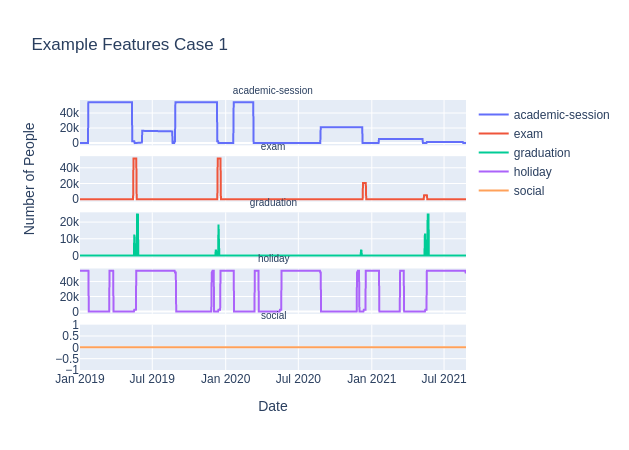

In [44]:
plot_case_features(df_case_1, 'Case 1')

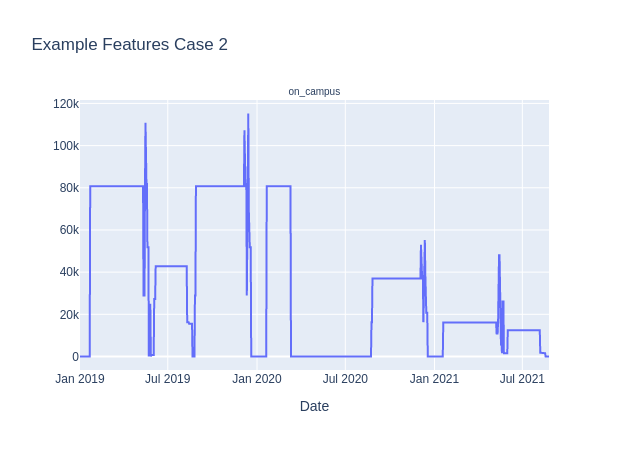

In [45]:
plot_case_features(df_case_2, 'Case 2')

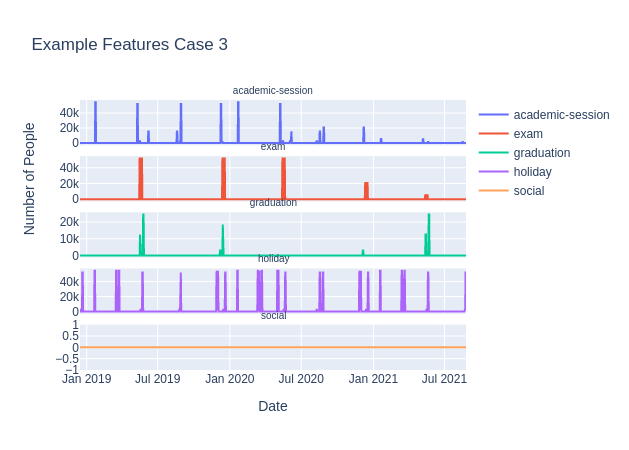

In [46]:
plot_case_features(df_case_3, 'Case 3')